In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import tree 
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as pyplot
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support

from warnings import simplefilter
import time
start = time.time()

In [68]:
df = pd.read_csv("pretrained.csv", low_memory=False)
labels = df['class']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=69)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [26]:
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=1000)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000)

In [ ]:
class DNNMulticlass(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(33, 50) # 33 features => X_train.shape[1]
        self.layer2 = nn.Linear(50, 30)
        self.layer3 = nn.Linear(30, 20)
        self.out_layer = nn.Linear(20, 6) # 6 classifications =>  y_train.value_counts()

    def forward(self, x):
        x = F.leaky_relu(self.layer1(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer2(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer3(x), negative_slope=0.05)
        x = self.out_layer(x) 
        return x

In [27]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [30]:
# Training script

model_dnn = DNNMulticlass()
early_stopping = EarlyStopping(patience=10, delta=0.001) # If model doesn't improve by 0.001 in "patience" steps, end training 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_dnn.parameters(), lr=0.001)

training_losses = []
validation_losses = []

epochs = 10
for epoch in range(epochs): 
    model_dnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        # Feed forward + backpropogate
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_dnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model_dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')

Epoch [1/10], Training Loss: 0.0460, Validation Loss: 0.0576
Epoch [2/10], Training Loss: 0.0202, Validation Loss: 0.0652
Epoch [3/10], Training Loss: 0.0156, Validation Loss: 0.0625
Epoch [4/10], Training Loss: 0.0143, Validation Loss: 0.0599
Epoch [5/10], Training Loss: 0.0137, Validation Loss: 0.0605
Epoch [6/10], Training Loss: 0.0134, Validation Loss: 0.0604
Epoch [7/10], Training Loss: 0.0131, Validation Loss: 0.0604
Epoch [8/10], Training Loss: 0.0129, Validation Loss: 0.0589
Epoch [9/10], Training Loss: 0.0129, Validation Loss: 0.0546
Epoch [10/10], Training Loss: 0.0128, Validation Loss: 0.0547
Finished Training


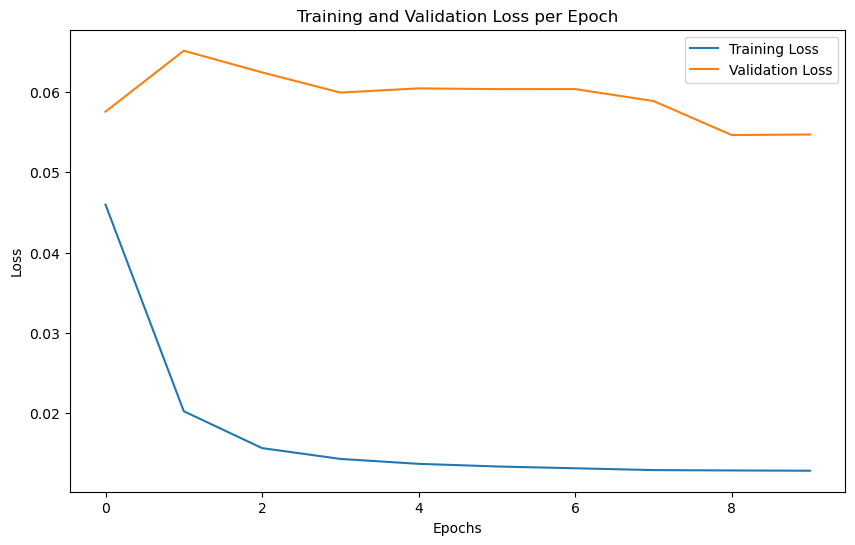

In [31]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()